In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import date

sns.set_style("whitegrid", {'axes.grid' : False})

In [3]:
fifa = pd.read_csv("fifa21.csv", index_col=0)

In [4]:
fifa.head()

Name  Age  OVA            Nationality           Club   BP Height  \
ID                                                                            
2   G. Pasquale   33   69                  Italy        Udinese  LWB   6'0"   
16  Luis García   37   71                  Spain      KAS Eupen   CM  5'10"   
27      J. Cole   33   71                England  Coventry City  CAM   5'9"   
36     D. Yorke   36   68  Trinidad &amp; Tobago     Sunderland   ST  5'11"   
41      Iniesta   36   81                  Spain    Vissel Kobe  CAM   5'7"   

    Weight   foot  Growth  ...  W/F  SM   IR  PAC SHO PAS DRI  DEF  PHY    GK  
ID                         ...                                                 
2   181lbs   Left       0  ...  3 ★  2★  2 ★   71  59  70  71   68   69  17+0  
16  143lbs  Right       0  ...  4 ★  3★  1 ★   53  69  73  69   58   63  17+1  
27  161lbs  Right       0  ...  4 ★  4★  2 ★   45  68  76  77   36   52  15+0  
36  165lbs  Right      14  ...  3 ★  1★  1 ★   61  66  66  69   47   60  22+0  
41  150lbs  Right       0  ...  4 ★  4★  4 ★   58  70  85  85   63   59  17+3  

[5 rows x 24 columns]

In [5]:
fifa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17125 entries, 2 to 259105
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         17125 non-null  object
 1   Age          17125 non-null  int64 
 2   OVA          17125 non-null  int64 
 3   Nationality  17125 non-null  object
 4   Club         17102 non-null  object
 5   BP           17125 non-null  object
 6   Height       17125 non-null  object
 7   Weight       17125 non-null  object
 8   foot         17125 non-null  object
 9   Growth       17125 non-null  int64 
 10  Joined       17067 non-null  object
 11  Value        17125 non-null  object
 12  Wage         17125 non-null  object
 13  Total Stats  17125 non-null  int64 
 14  W/F          17125 non-null  object
 15  SM           17125 non-null  object
 16  IR           17125 non-null  object
 17  PAC          17125 non-null  int64 
 18  SHO          17125 non-null  int64 
 19  PAS          17125 non-n

In [6]:
names = fifa.Name
fifa = fifa.drop("Name", axis=1)

# Pre-Processing

In [7]:
#Height inches to centimeters
feet = fifa.Height.str.split("'", expand=True)[0]
inches =fifa.Height.str.split("'", expand=True)[1].str.replace('"','')

total_inches = feet.astype(int)*12 + inches.astype(int)
total_cm = total_inches*2.54

fifa.Height = total_cm

#Weight Lbs to kg
fifa.Weight = fifa.Weight.str[:-3].astype(int)*0.45

#Joined to months in club conversion
delta = pd.to_datetime(fifa.Joined)
delta = datetime.datetime.now().date() - delta.dt.date
delta = delta.dt.days
delta = delta.fillna(0)
fifa.Joined = delta.astype(int)/30

#Converting Value and Wage to Numerical
def converter(hmm):
    val = hmm[1:-1]
    if val == "":
        val="0"
    val = float(val)
    coef = hmm[-1]
    if coef =="M":
        coef = 1000000
    elif coef=="K":
        coef = 1000
    else: coef = 1
    total_val = val * coef
    return total_val

fifa["Value"] = fifa.Value.apply(converter).astype(float)
fifa["Wage"] = fifa.Wage.apply(converter).astype(float)

#Converting Star Variables to Numeric
fifa["W/F"] = fifa["W/F"].str[0].astype(int)
fifa["SM"] = fifa["SM"].str[0].astype(int)
fifa["IR"] = fifa["IR"].str[0].astype(int)

#Simplify GK Column
fifa["GK"] = fifa.GK.str.split("+",expand=True)[0].astype(int)

#Log of Wage Value columns
logWage = fifa.Wage.replace(0,1)
fifa["Wage"] = np.log(logWage)

logValue = fifa.Value.replace(0,1)
fifa["Value"] = np.log(logValue)

#Simplifying player positions
defenders = ["CB", "LB", "RB", "LWB", "RWB"]
midfielders = ["CDM","CM","CAM","LM", "RM"]
forwards = ["ST", "CF", "LW", "RW"]

conditions = [
    (fifa.BP.isin(defenders)),
    (fifa.BP.isin(midfielders)),
    (fifa.BP.isin(forwards)),
    fifa.BP == "GK"
    ]

values = ['Defender', 'Midfield', 'Forward', 'Goalkeeper']
fifa['Position'] = np.select(conditions, values)

#Getting League Info
leaguedf = pd.read_csv("players_21.csv", index_col=0)
fifa_league = pd.merge(fifa, leaguedf.league_name, left_index=True, right_index=True, how="left")


#Feature Engineering Work Rate stat
fifa_full = pd.read_csv("fifa21_full.csv", index_col=0)
fifa_full = fifa_full[["A/W","D/W"]]
fifa_full = fifa_full.dropna()

condition = [(fifa_full["A/W"]=="High")&(fifa_full["D/W"]=="High"),
             (fifa_full["A/W"]=="Medium")&(fifa_full["D/W"]=="High"),
             (fifa_full["A/W"]=="High")&(fifa_full["D/W"]=="Medium"),
             (fifa_full["A/W"]=="High")&(fifa_full["D/W"]=="Low"),
             (fifa_full["A/W"]=="Low")&(fifa_full["D/W"]=="High"), 
             (fifa_full["A/W"]=="Medium")&(fifa_full["D/W"]=="Medium"),
             (fifa_full["A/W"]=="Medium")&(fifa_full["D/W"]=="Low"),
             (fifa_full["A/W"]=="Low")&(fifa_full["D/W"]=="Medium"),
             (fifa_full["A/W"]=="Low")&(fifa_full["D/W"]=="Low")]

choice = ["High","High","High","Medium","Medium", "Medium", "Low", "Low", "Low"]

fifa_full["WorkRate"] = np.select(condition, choice)

fifa_wr = pd.merge(fifa_league, fifa_full.WorkRate, right_index=True, left_index=True)




C:\Users\oguzk\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (78) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Recheking the dataframe fifa

In [8]:
fifa_wr.head()

Age  OVA Nationality              Club   BP  Height  Weight   foot  \
ID                                                                       
2    33   69       Italy           Udinese  LWB  182.88   81.45   Left   
16   37   71       Spain         KAS Eupen   CM  177.80   64.35  Right   
27   33   71     England     Coventry City  CAM  175.26   72.45  Right   
41   36   81       Spain       Vissel Kobe  CAM  170.18   67.50  Right   
61   27   66     Germany  Alemannia Aachen   RW  172.72   73.35  Right   

    Growth      Joined  ...  PAC  SHO  PAS  DRI  DEF  PHY  GK  Position  \
ID                      ...                                               
2        0  153.200000  ...   71   59   70   71   68   69  17  Defender   
16       0   79.566667  ...   53   69   73   69   58   63  17  Midfield   
27       0   61.666667  ...   45   68   76   77   36   52  15  Midfield   
41       0   30.966667  ...   58   70   85   85   63   59  17  Midfield   
61       4  122.733333  ...   91   56   56   67   27   63  13   Forward   

                      league_name  WorkRate  
ID                                           
2                             NaN      High  
16                            NaN    Medium  
27                            NaN       Low  
41  Japanese J. League Division 1      High  
61                            NaN    Medium  

[5 rows x 26 columns]

In [9]:
fifa_wr.describe()

Age           OVA        Height        Weight        Growth  \
count  17036.000000  17036.000000  17036.000000  17036.000000  17036.000000   
mean      25.246419     66.948403    181.218623     74.534222      5.514381   
std        4.920975      6.840553      6.887079      7.110888      5.791736   
min       16.000000     45.000000    154.940000     49.500000      0.000000   
25%       21.000000     62.000000    175.260000     69.300000      0.000000   
50%       25.000000     67.000000    180.340000     74.250000      4.000000   
75%       29.000000     72.000000    185.420000     79.200000      9.000000   
max       53.000000     93.000000    205.740000    109.350000     26.000000   

             Joined         Value          Wage   Total Stats           W/F  \
count  17036.000000  17036.000000  17036.000000  17036.000000  17036.000000   
mean      33.798507     13.506762      7.770697   1632.186781      2.985384   
std       29.287300      2.413739      2.289875    259.980265      0.672639   
min        4.033333      0.000000      0.000000    731.000000      1.000000   
25%       16.791667     12.834681      6.907755   1493.000000      3.000000   
50%       25.333333     13.592367      8.006368   1660.000000      3.000000   
75%       43.633333     14.690979      9.305651   1812.000000      3.000000   
max      367.266667     18.474222     13.235692   2316.000000      5.000000   

                 SM            IR           PAC           SHO           PAS  \
count  17036.000000  17036.000000  17036.000000  17036.000000  17036.000000   
mean       2.457560      1.145985     68.090984     54.941594     58.907079   
std        0.777672      0.446618     11.155446     13.861745     10.173187   
min        1.000000      1.000000     25.000000     16.000000     25.000000   
25%        2.000000      1.000000     62.000000     46.000000     52.000000   
50%        2.000000      1.000000     69.000000     58.000000     60.000000   
75%        3.000000      1.000000     75.000000     65.000000     66.000000   
max        5.000000      5.000000     96.000000     93.000000     93.000000   

                DRI           DEF           PHY            GK  
count  17036.000000  17036.000000  17036.000000  17036.000000  
mean      64.198169     50.254931     64.899566     20.723820  
std        9.822388     16.844544      9.648599     14.575141  
min       28.000000     12.000000     27.000000      8.000000  
25%       59.000000     35.000000     59.000000     15.000000  
50%       65.000000     53.000000     66.000000     16.000000  
75%       71.000000     64.000000     72.000000     18.000000  
max       95.000000     91.000000     91.000000     89.000000

In [10]:
fifa_wr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17036 entries, 2 to 259105
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          17036 non-null  int64  
 1   OVA          17036 non-null  int64  
 2   Nationality  17036 non-null  object 
 3   Club         17018 non-null  object 
 4   BP           17036 non-null  object 
 5   Height       17036 non-null  float64
 6   Weight       17036 non-null  float64
 7   foot         17036 non-null  object 
 8   Growth       17036 non-null  int64  
 9   Joined       17036 non-null  float64
 10  Value        17036 non-null  float64
 11  Wage         17036 non-null  float64
 12  Total Stats  17036 non-null  int64  
 13  W/F          17036 non-null  int32  
 14  SM           17036 non-null  int32  
 15  IR           17036 non-null  int32  
 16  PAC          17036 non-null  int64  
 17  SHO          17036 non-null  int64  
 18  PAS          17036 non-null  int64  
 19  DRI

# Explanatory Data Analysis

In [11]:
#Get metric and non-metric columns
metric_cols = fifa_wr.columns[(fifa_wr.dtypes == "float64") | (fifa_wr.dtypes == "int64") | (fifa_wr.dtypes == "int32") ]
nonmetric_cols = fifa_wr.columns[fifa_wr.dtypes == "object"]

metric_simpl = ['Age', 'OVA', 'Height', 'Weight', 'Growth', 'Joined', 'Value', 'Wage',
       'Total Stats']


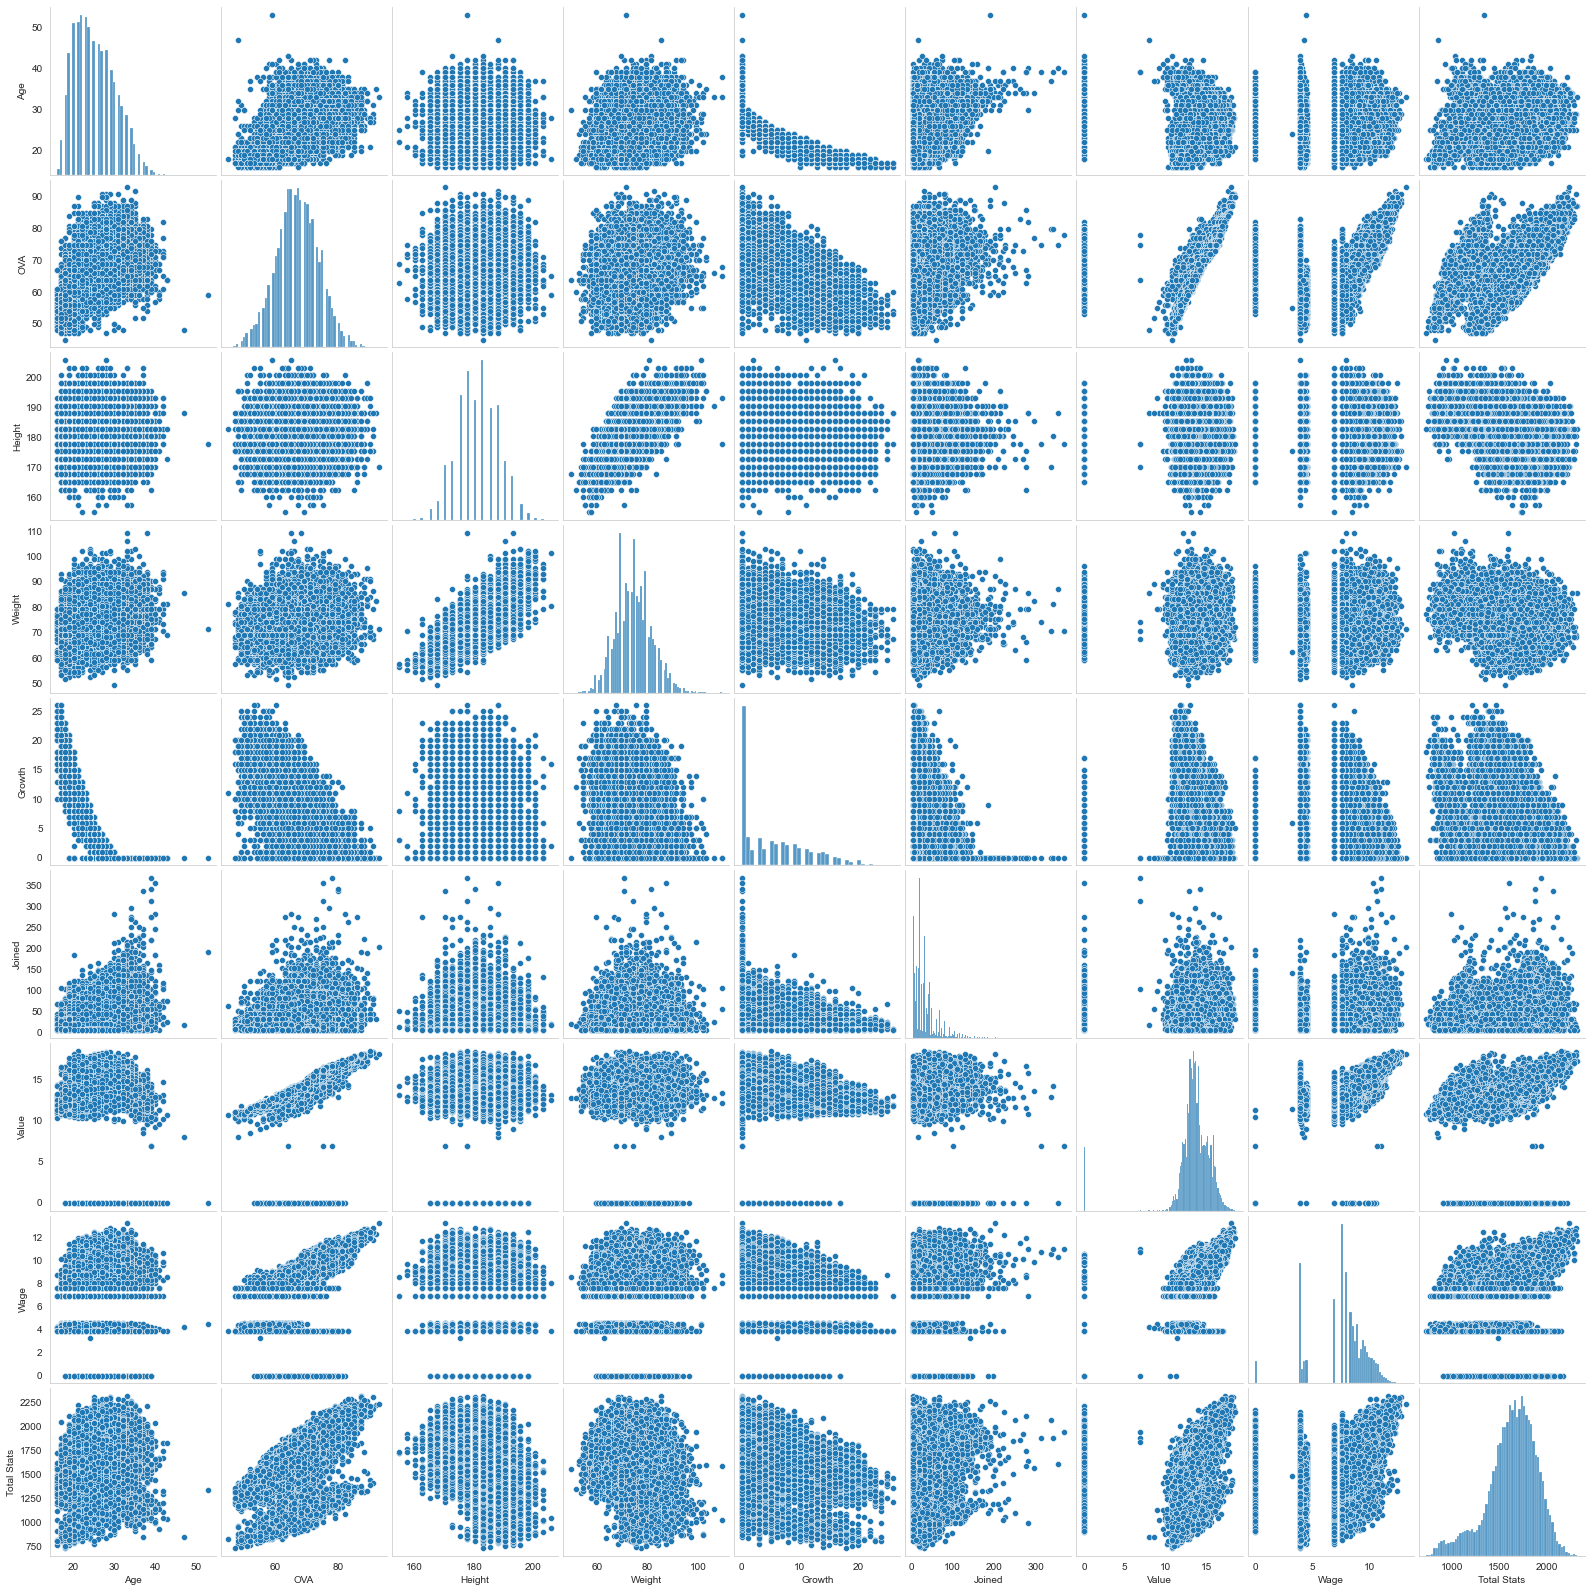

In [12]:
sns.pairplot(fifa_wr[metric_simpl])

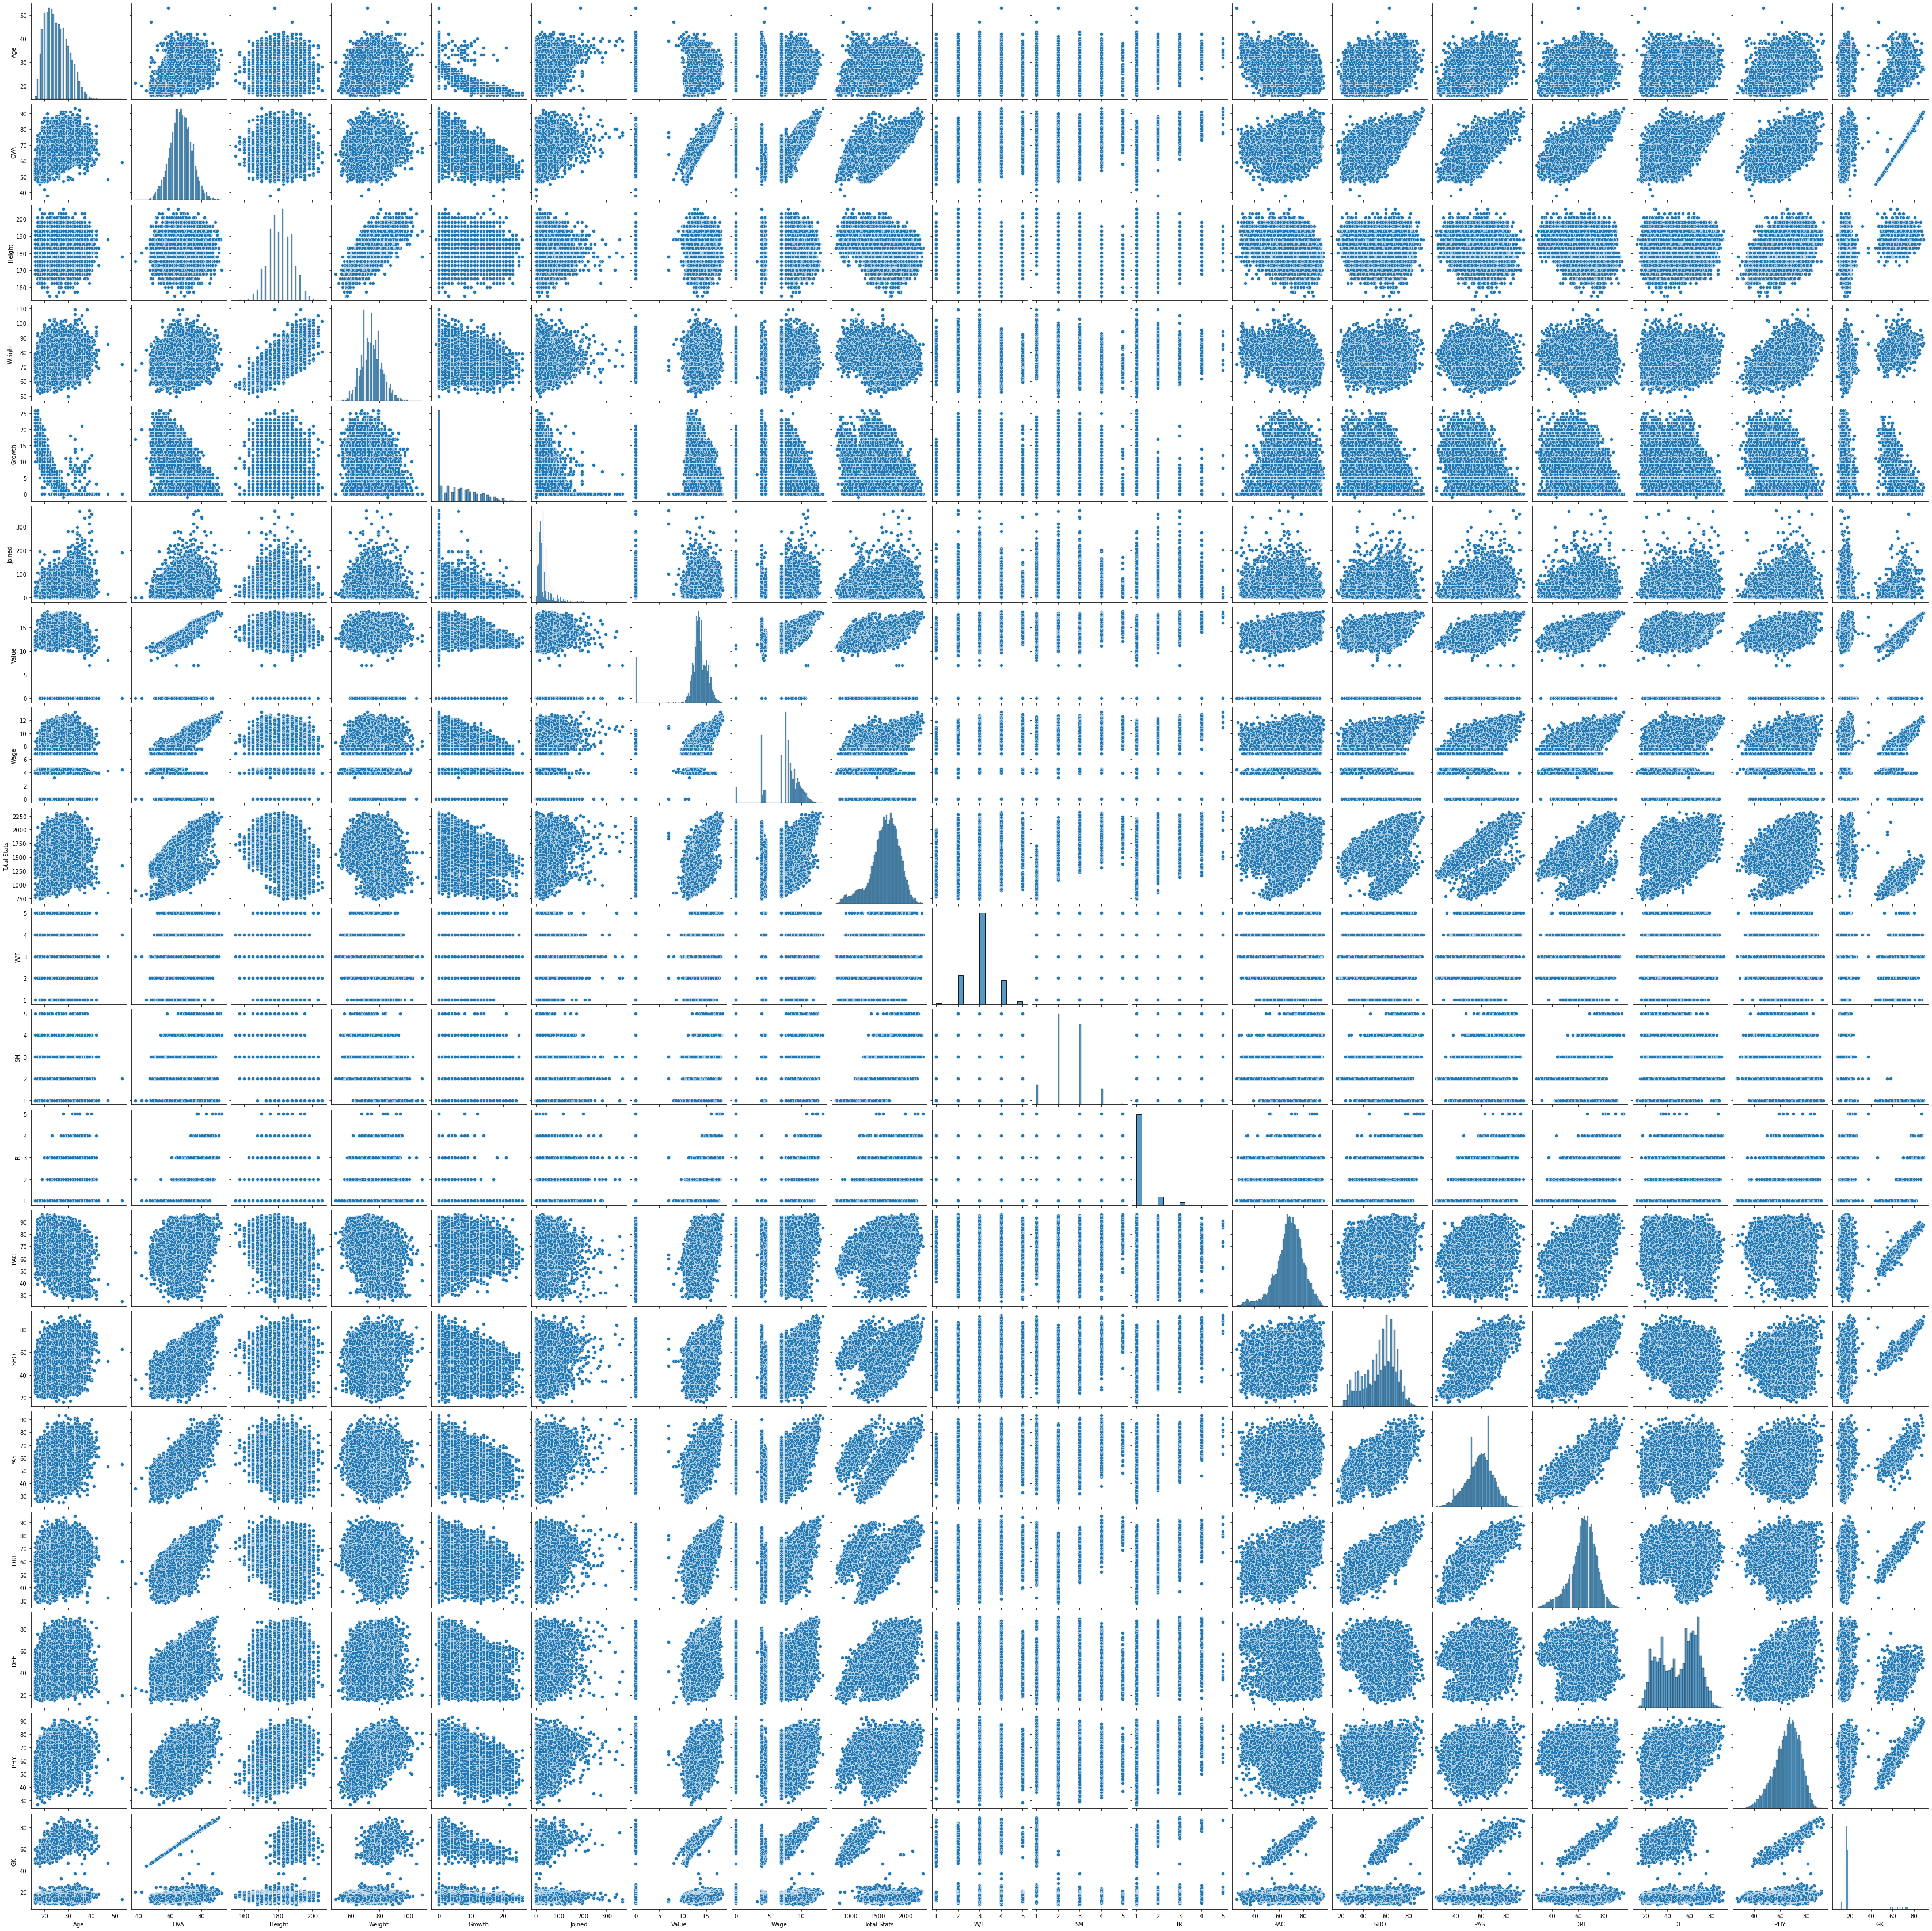

In [13]:
sns.pairplot(fifa[metric_cols])

### Correlation Heatmap

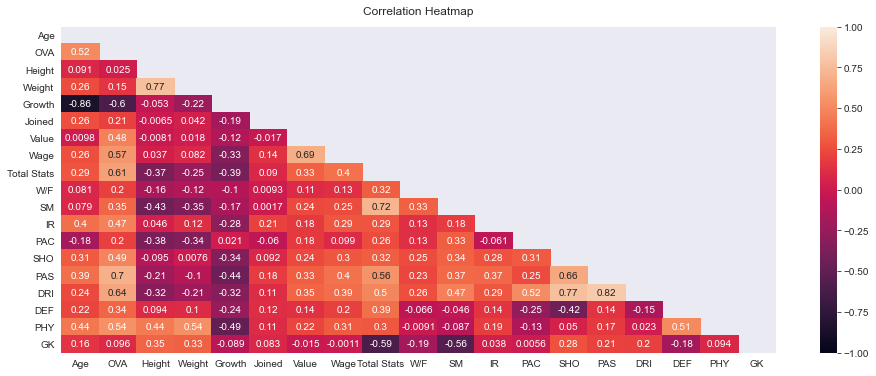

In [23]:
# Increase the size of the heatmap.
plt.figure(figsize=(16,10))
mask = np.triu(np.ones_like(fifa_wr[metric_cols].corr(), dtype=np.bool))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).

# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(fifa_wr[metric_cols].corr(), mask=mask, vmin=-1, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


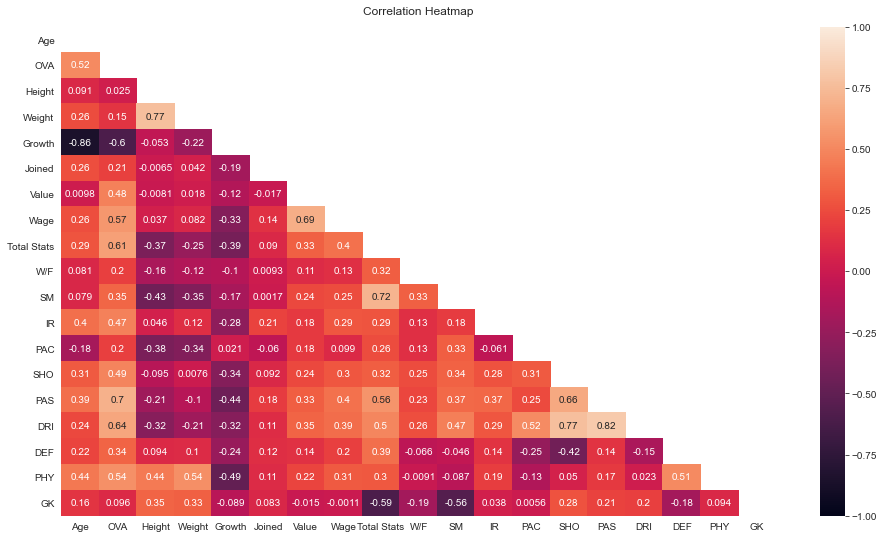

In [17]:
# Increase the size of the heatmap.
mask = np.triu(np.ones_like(fifa_wr[metric_cols].corr(), dtype=np.bool))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).

# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.

a4_dims = (16, 9)
fig, ax = plt.subplots(figsize=a4_dims)


heatmap = sns.heatmap(fifa_wr[metric_cols].corr(), mask=mask, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


#ax.axis("off")
#sns.despine(right=True, left=True)

#ax.set_xticks([])
#ax.set_yticks([])

plt.savefig('corr.png', transparent=True)

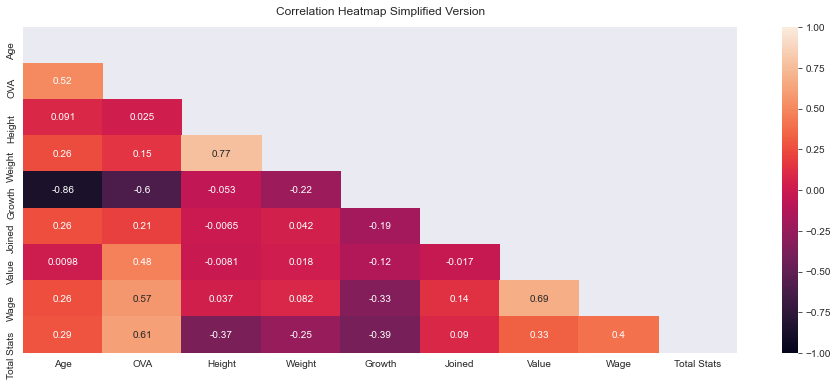

In [26]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))

mask = np.triu(np.ones_like(fifa_wr[metric_simpl].corr(), dtype=np.bool))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).

# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(fifa_wr[metric_simpl].corr(), mask=mask, vmin=-1, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap Simplified Version', fontdict={'fontsize':12}, pad=12);

# Detailed Analysis 
## Burning Questions

#### 1- Is Premier League more physical according to FIFA?

In [28]:
fifa_wr.league_name.value_counts()

English Premier League                  645
English League Championship             639
Italian Serie A                         608
Spain Primera Division                  607
USA Major League Soccer                 604
French Ligue 1                          582
German 1. Bundesliga                    535
Spanish Segunda División                488
English League Two                      479
English League One                      474
German 2. Bundesliga                    434
Argentina Primera División              430
German 3. Bundesliga                    424
Mexican Liga MX                         413
Holland Eredivisie                      411
Portuguese Liga ZON SAGRES              397
French Ligue 2                          391
Belgian Jupiler Pro League              384
Turkish Süper Lig                       380
Japanese J. League Division 1           298
Polish T-Mobile Ekstraklasa             282
Swedish Allsvenskan                     248
Norwegian Eliteserien           

C:\Users\oguzk\anaconda3\lib\site-packages\seaborn\distributions.py:2163: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try kdeplot.
  warnings.warn(msg, UserWarning)


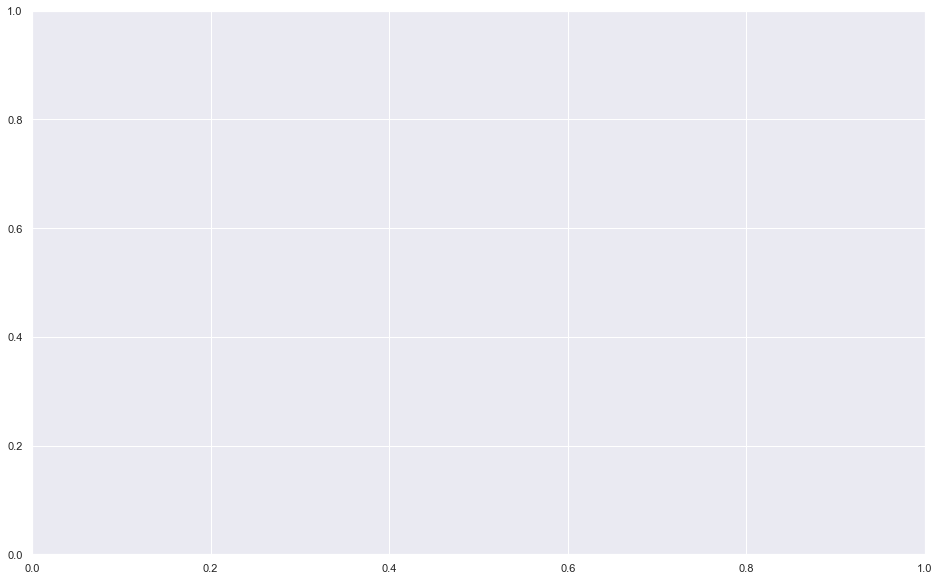

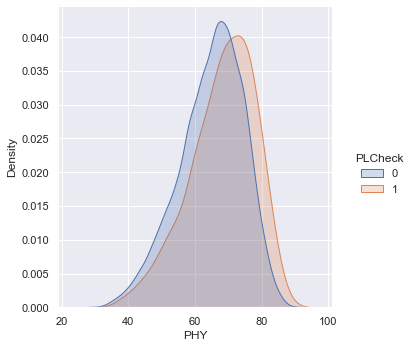

In [116]:
#PL Check
fifa_wr["PLCheck"] = np.where(fifa_wr['league_name'] == "English Premier League", 1, 0)


# Sort the dataframe by target
PHY_PL = fifa_wr[fifa_wr.league_name == "English Premier League"].PHY
PHY_Others = fifa_wr[fifa_wr.league_name != "English Premier League"].PHY


a4_dims = (16, 10)
fig, ax = plt.subplots(figsize=a4_dims)

sns.displot(data=fifa_wr[fifa_wr.Position != "Goalkeeper"], ax=ax, x="PHY", hue="PLCheck",kind="kde",legend=True, common_norm=False, fill=True)

plt.show()


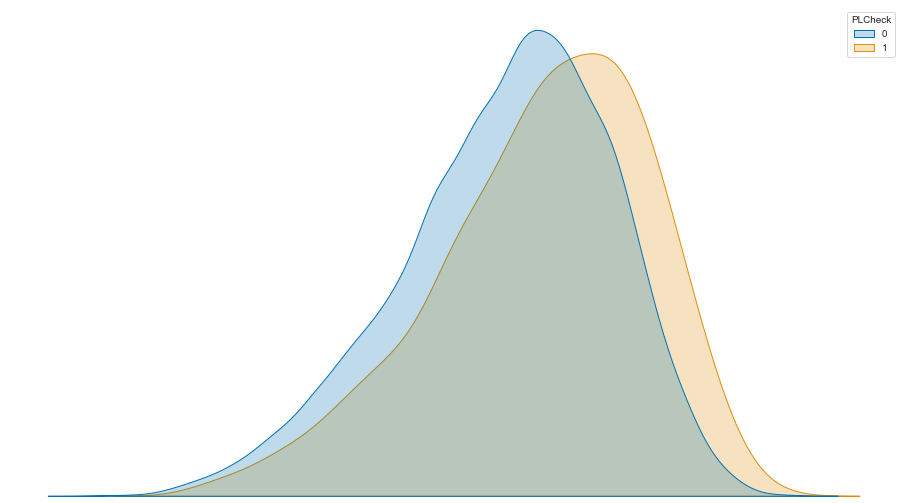

In [22]:
#PL Check
fifa_wr["PLCheck"] = np.where(fifa_wr['league_name'] == "English Premier League", 1, 0)


# Sort the dataframe by target
PHY_PL = fifa_wr[fifa_wr.league_name == "English Premier League"].PHY
PHY_Others = fifa_wr[fifa_wr.league_name != "English Premier League"].PHY


a4_dims = (16, 9)
fig, ax = plt.subplots(figsize=a4_dims)

sns.set_palette("colorblind")

sns.kdeplot(data=fifa_wr[fifa_wr.Position != "Goalkeeper"], ax=ax, x="PHY", hue="PLCheck", common_norm=False, fill=True)

ax.axis("off")
sns.despine(right=True, left=True)

ax.set_xticks([])
ax.set_yticks([])

plt.savefig('q1.png', transparent=True)

In [25]:
import scipy.stats as stats

# Perform the two-sample t-test
t_result= stats.ttest_ind(PHY_PL, PHY_Others, equal_var=False)
print(t_result)

# Test significance
alpha= 0.05
if (t_result[1] < alpha):
    print("There is a significant difference between the distributions.")
else: print("No significant difference found")

Ttest_indResult(statistic=9.643484328425927, pvalue=9.723956260384796e-21)
There is a significant difference between the distributions.


In [26]:
#from __future__ import print_function

#import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

np.random.seed(1)

# Create sample data.
a = PHY_PL
b = PHY_Others

# Use scipy.stats.ttest_ind.
t, p = stats.ttest_ind(a, b, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

# Compute the descriptive statistics of a and b.
abar = a.mean()
avar = a.var(ddof=1)
na = a.size
adof = na - 1

bbar = b.mean()
bvar = b.var(ddof=1)
nb = b.size
bdof = nb - 1

# Use scipy.stats.ttest_ind_from_stats.
t2, p2 = stats.ttest_ind_from_stats(abar, np.sqrt(avar), na,
                              bbar, np.sqrt(bvar), nb,
                              equal_var=False)
print("ttest_ind_from_stats: t = %g  p = %g" % (t2, p2))

# Use the formulas directly.
tf = (abar - bbar) / np.sqrt(avar/na + bvar/nb)
dof = (avar/na + bvar/nb)**2 / (avar**2/(na**2*adof) + bvar**2/(nb**2*bdof))
pf = 2*stdtr(dof, -np.abs(tf))

print("formula:              t = %g  p = %g" % (tf, pf))

ttest_ind:            t = 9.64348  p = 9.72396e-21
ttest_ind_from_stats: t = 9.64348  p = 9.72396e-21
formula:              t = 9.64348  p = 9.72396e-21


In [34]:
TR_phy = fifa_league.PHY[fifa_league.league_name=="Turkish Süper Lig"]
nonTR_phy = fifa_league.PHY[fifa_league.league_name !="Turkish Süper Lig"]

C:\Users\oguzk\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\oguzk\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PHY', ylabel='Density'>

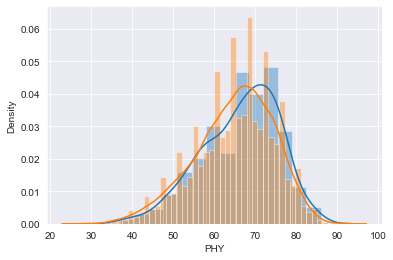

In [35]:
sns.distplot(TR_phy)
sns.distplot(nonTR_phy)

In [36]:
import scipy.stats as stats

# Perform the two-sample t-test
t_result= stats.ttest_ind(TR_phy, nonTR_phy)
print(t_result)

# Test significance
alpha= 0.05
if (t_result[1] < alpha):
    print("There is a significant difference between the distributions.")
else: print("No significant difference found")

Ttest_indResult(statistic=2.851794887817787, pvalue=0.004352515944146931)
There is a significant difference between the distributions.


<AxesSubplot:xlabel='PLCheck', ylabel='PHY'>

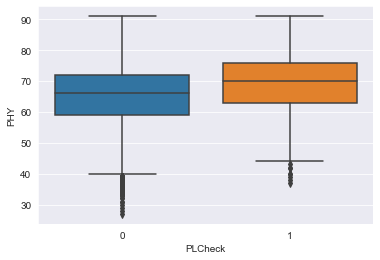

In [39]:
sns.boxplot(data=fifa_wr, y="PHY", x="PLCheck")

In [ ]:
#Performing the 2-way t-test

#### 2) The best leaue/team in Europe Leaue?

This also can be the best team in the league, PSG Bayern etc.
Or national team wise, is there a difference?


<AxesSubplot:xlabel='league_name', ylabel='OVA'>

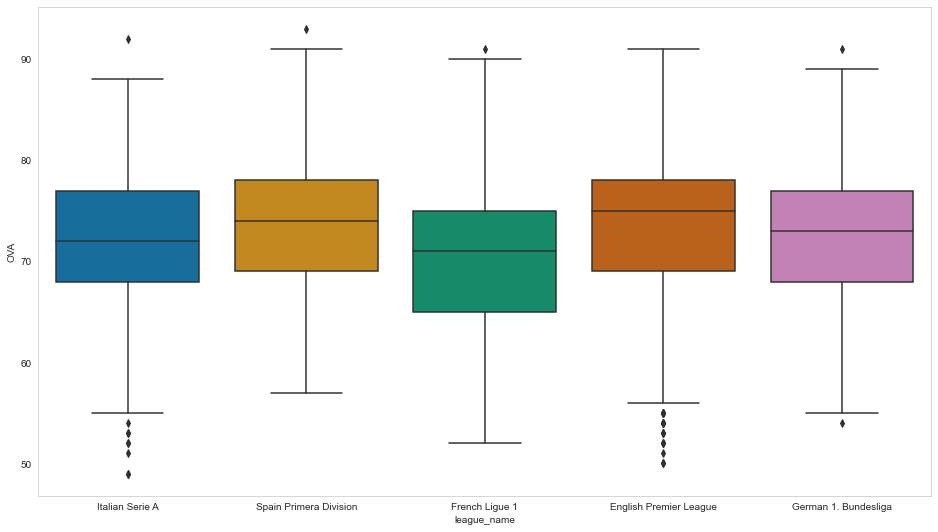

In [28]:
top5_leagues = ["English Premier League", "Italian Serie A", "Spain Primera Division", "French Ligue 1", "German 1. Bundesliga"]


fig, ax = plt.subplots(figsize=a4_dims)


sns.boxplot(data=fifa_wr[fifa_wr.league_name.isin(top5_leagues)], y="OVA", x="league_name")

#ax.axis("off")
#sns.despine(right=True, left=True)

#plt.savefig('q21.png', transparent=True)



In [75]:
fifa_wr[fifa_wr.league_name.isin(top5_leagues)].groupby("league_name").OVA.mean()

league_name
English Premier League    73.258915
French Ligue 1            70.154639
German 1. Bundesliga      71.923364
Italian Serie A           71.965461
Spain Primera Division    73.364086
Name: OVA, dtype: float64

In [74]:
# Create arrays
PL_players = fifa_wr[fifa_wr.league_name == "English Premier League"].OVA
BL_players = fifa_wr[fifa_wr.league_name == "German 1. Bundesliga"].OVA
LL_players = fifa_wr[fifa_wr.league_name == "Spain Primera Division"].OVA
SA_players = fifa_wr[fifa_wr.league_name == "Italian Serie A"].OVA
L1_players = fifa_wr[fifa_wr.league_name == "French Ligue 1"].OVA


# Perform one-way ANOVA
anova = stats.f_oneway(PL_players, BL_players, LL_players, SA_players, L1_players)
print(anova)

if (anova[1] < alpha):
    print("There is a significant difference between the top 5 leagues' player ratings.")
else: print("No significant difference found")

F_onewayResult(statistic=19.678329787950336, pvalue=5.307551910497147e-16)
There is a significant difference between the distributions.


In [72]:
deneme= stats.ttest_ind(PL_players, LL_players)
print(deneme)


Ttest_indResult(statistic=-0.2476612840164456, pvalue=0.8044371636057359)


#### 2.5) Is midfield the toughest position  on the pitch?

<AxesSubplot:xlabel='Total Stats', ylabel='Position'>

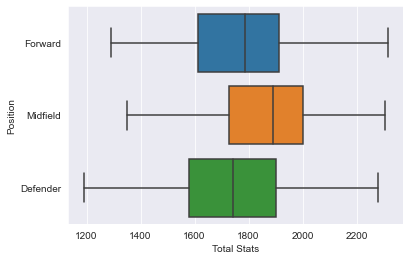

In [42]:


sns.boxplot(data=fifa_wr[(fifa_wr.league_name.isin(top5_leagues)) & (fifa_wr.Position != "Goalkeeper")], x="Total Stats", y="Position")

#### 3) Are there more hard working midfielders than other positions?
You'll need an extra lung if you're in the middle

In [44]:
fifa_wr.WorkRate.value_counts()

Medium    9595
High      6000
Low       1441
Name: WorkRate, dtype: int64

<AxesSubplot:xlabel='Position', ylabel='count'>

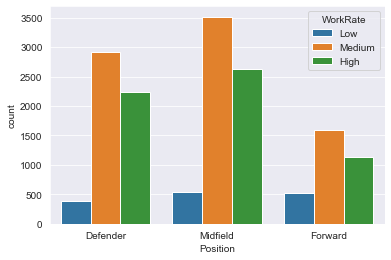

In [45]:
sns.countplot(x="Position", hue="WorkRate", data=fifa_wr[fifa_wr.Position != "Goalkeeper"], order= ["Defender", "Midfield", "Forward"], hue_order=["Low", "Medium", "High"])

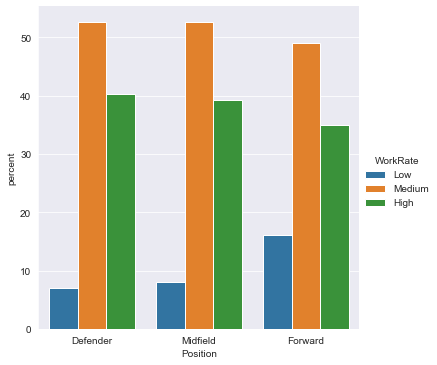

In [46]:
x,y = 'Position', 'WorkRate'

(fifa_wr[fifa_wr.Position != "Goalkeeper"]
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar', order= ["Defender", "Midfield", "Forward"], hue_order=["Low", "Medium", "High"]))

#### 3.5) The Modern Fullback: Hardest Position on the pitch
Do we expect too much from the new fullbacks?

In [75]:
fifa_league.shape

(17125, 26)

In [60]:
fifa_wr.BP.value_counts()

CB     2603
ST     2095
CAM    1776
GK     1294
RM     1154
CDM    1031
CM      814
LB      805
RB      758
LM      670
RW      235
RWB     210
LWB     209
LW      148
CF       60
Name: BP, dtype: int64

In [49]:
rcondition = [fifa_wr["BP"]=="GK",
              fifa_wr["BP"]=="CB",
              (fifa_wr["BP"]=="LB")|(fifa_wr["BP"]=="RB")|(fifa_wr["BP"]=="RWB")|(fifa_wr["BP"]=="LWB"),
              (fifa_wr["BP"]=="CDM")|(fifa_wr["BP"]=="CM")|(fifa_wr["BP"]=="CAM"),
              (fifa_wr["BP"]=="LM")|(fifa_wr["BP"]=="LW")|(fifa_wr["BP"]=="RW")|(fifa_wr["BP"]=="RM"),
              (fifa_wr["BP"]=="CF")|(fifa_wr["BP"]=="ST")]

rchoice = ["Goalkeeper", "Centre Back","Wing Back","Central Midfielder","Winger","Striker"]

fifa_wr["Role"] = np.select(rcondition, rchoice)

[]

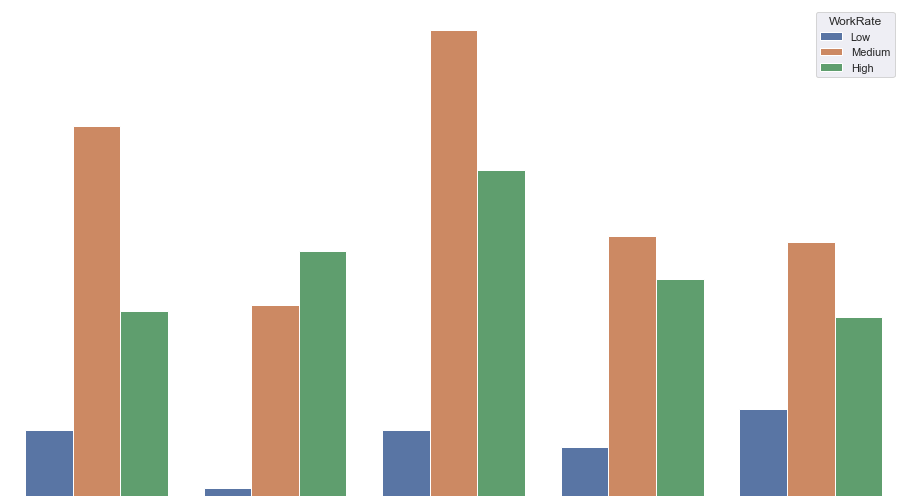

In [132]:
fig, ax = plt.subplots(figsize=a4_dims)


sns.countplot(x="Role", hue="WorkRate", data=fifa_wr[fifa_wr.Position != "Goalkeeper"], order=["Centre Back","Wing Back","Central Midfielder","Winger","Striker"], hue_order=["Low", "Medium", "High"])
ax.axis("off")
sns.despine(right=True, left=True)

#ax.set_xticks([])
ax.set_yticks([])

#plt.savefig('q3.png', transparent=True)




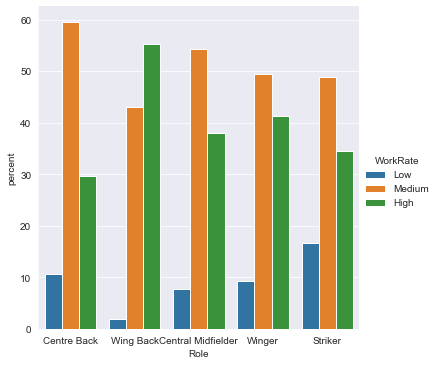

In [54]:
x,y = 'Role', 'WorkRate'

(fifa_wr[fifa_wr.Position != "Goalkeeper"]
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar', order= ["Centre Back","Wing Back","Central Midfielder","Winger","Striker"], hue_order=["Low", "Medium", "High"]))

In [85]:
order=["Centre Back","Wing Back","Central Midfielder","Winger","Striker"]
hue_order=["Low", "Medium", "High"]

ct_rolerate= pd.crosstab(index=fifa_wr[fifa_wr.Position != "Goalkeeper"]['Role'], 
            columns=fifa_wr[fifa_wr.Position != "Goalkeeper"]['WorkRate']
           ).reindex(order).reindex(hue_order, axis="columns")

In [86]:
ct_rolerate

WorkRate            Low  Medium  High
Role                                 
Centre Back         345    1927   962
Wing Back            43     995  1278
Central Midfielder  345    2428  1696
Winger              254    1353  1130
Striker             454    1325   934

In [91]:
chi2_stat, p_val, dof, ex = stats.chi2_contingency(ct_rolerate)
print("===Chi2 Stat===")
print(chi2_stat)
print("\n")
print("===Degrees of Freedom===")
print(dof)
print("\n")
print("===P-Value===")
print(p_val)
print("\n")
print("===Contingency Table===")
print(ex)

===Chi2 Stat===
649.9716913377835


===Degrees of Freedom===
8


===P-Value===
4.186950191338163e-135


===Contingency Table===
[[ 301.26019781 1678.36007499 1254.3797272 ]
 [ 215.74477988 1201.94246558  898.31275454]
 [ 416.30544961 2319.29226194 1733.40228845]
 [ 254.96263495 1420.43027991 1061.60708514]
 [ 252.72693775 1407.97491758 1052.29814468]]


#### 3.5.2) Reputation vs. Position

<AxesSubplot:xlabel='Role', ylabel='count'>

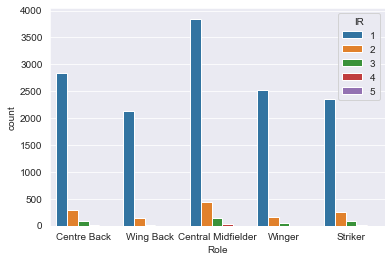

In [76]:
sns.countplot(x="Role", hue="IR", data=fifa_wr[fifa_wr.Position != "Goalkeeper"], order=["Centre Back","Wing Back","Central Midfielder","Winger","Striker"])

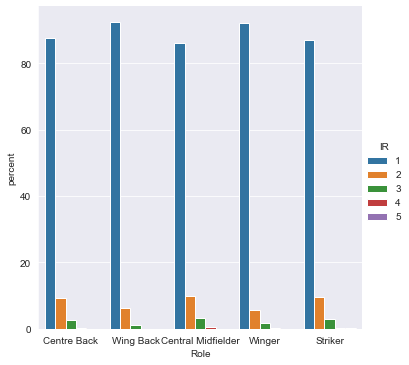

In [77]:
x,y = 'Role', 'IR'

(fifa_wr[fifa_wr.Position != "Goalkeeper"]
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar', order= ["Centre Back","Wing Back","Central Midfielder","Winger","Striker"]))

In [71]:
fifa_wr[fifa_wr.league_name=="English Premier League"].groupby("Club")["OVA"].mean().sort_values()

Club
Hull City                  58.000000
Reading                    60.000000
Oldham Athletic            61.000000
Gillingham                 62.000000
Plymouth Argyle            66.000000
Leeds United               68.187500
West Bromwich Albion       68.718750
Wolverhampton Wanderers    69.636364
Fulham                     70.062500
Sheffield United           70.333333
Trabzonspor                71.000000
Aston Villa                71.060606
West Ham United            71.303030
Burnley                    71.344828
Crystal Palace             71.454545
Southampton                71.483871
Brighton & Hove Albion     71.700000
Newcastle United           73.781250
Everton                    74.843750
Leicester City             75.281250
Fenerbahçe SK              76.000000
Arsenal                    76.212121
Tottenham Hotspur          77.242424
Manchester United          77.818182
1. FC Union Berlin         78.000000
Manchester City            78.275862
Liverpool                  78.593

In [93]:
fifa_wr[fifa_wr.Value==0].Age.value_counts()

32    33
30    31
27    27
26    26
31    25
29    25
28    24
24    22
36    18
34    16
33    16
23    15
35    11
25    11
22    11
21     9
40     9
37     8
39     8
20     6
38     4
41     4
42     4
18     2
43     1
19     1
53     1
Name: Age, dtype: int64